# Import libraries

In [839]:
import scipy as sc
from scipy.integrate import odeint
from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from mpl_toolkits import mplot3d
import pandas as pd

# Add real data

In [679]:
# --- ADD OUR DATA for fsigma_8 ----

z_data = [0.02,0.067,0.1,0.17,0.35,0.77,0.25,0.37,0.22,0.41,0.6,0.6,0.78,0.57,0.3,0.4,0.5,0.8]
fsigma8_data = [0.36,0.423,0.37,0.51,0.44,0.49,0.351,0.46,0.42,0.45,0.43,0.433,0.38,0.427,0.407,0.419,0.427,0.47]
err_data = [0.04,0.055,0.13,0.06,0.05,0.18,0.058,0.038,0.07,0.04,0.04,0.067,0.04,0.066,0.055,0.041,0.043,0.08]

# Find growth rate f to first order

In [855]:
#---- USEFUL FUNCTIONS for growth rate f ----

# Define xi, caracteristic function of 4DEGB. xi(alpha_C = 1) = 1
# note: k is unitless (ie. k is actually k/H0)
def xi(x,alpha_C, k, cosmo):
    return k**2/(k**2 - 6*alpha_C*np.exp(-2*x))
    # For example
    #Omega_c = cosmo['Omega_c']
    #Omega_b = cosmo['Omega_b']
    #Omega_m = Omega_c + Omega_b
    #O_m_GR = Omega_m*np.exp(-3*x)/E(x,cosmo,alpha_C, k)**2
    #return 1 + 0.75*(1-O_m_GR) - 1.5*(1-O_m_GR)**2 + 0.75*(1-O_m_GR)**3
    
def E(x,cosmo,alpha_C, k):
    Omega_c = cosmo['Omega_c']
    Omega_b = cosmo['Omega_b']
    Omega_k = cosmo['Omega_k']
    Omega_r = cosmo['Omega_g']
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
    
    return np.sqrt(Omega_m*np.exp(-3*x) + (Omega_r + alpha_C)*np.exp(-4*x) + Omega_k*np.exp(-2*x) + Omega_lambda)

def K(x1,x2,cosmo):
    Omega_m = cosmo['Omega_c'] + cosmo['Omega_b']
    Int = sc.integrate.quad(lambda x: f_LCDM(x,cosmo) + 3*Omega_m*np.exp(-3*x)\
                               /(2*f_LCDM(x,cosmo)), x1, x2)[0]
    return np.exp(Int)

def eta(x_v,cosmo,alpha_C,k):
    Omega_m = cosmo['Omega_c'] + cosmo['Omega_b']
    Int = sc.integrate.quad(lambda x: (xi(x,alpha_C, k,cosmo) - 1)*Omega_m*np.exp(-3*x)*K(x_v,x,cosmo)\
                               /f_LCDM(x,cosmo), -10 , x_v)[0]
    return 3*Int/2

# derivative of the growth rate f with the logarithm of the scale factor x = ln(a)
# for a LCDM universe
def dfdx_LCDM(f , x , cosmo):
    Omega_k = cosmo['Omega_k']
    Omega_r = cosmo['Omega_g']
    Omega_m = cosmo['Omega_c'] + cosmo['Omega_b']
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k
    
    return (3*Omega_m/(2*(Omega_m+Omega_r*np.exp(-x)+Omega_lambda*np.exp(3*x)+Omega_k*np.exp(x))) \
            - f**2 - (2-(3*Omega_m*np.exp(-3*x) + 4*Omega_r*np.exp(-4*x) + 2*Omega_k*np.exp(-2*x))/ \
                      (2*(Omega_k*np.exp(-2*x) + Omega_m*np.exp(-3*x) + Omega_r*np.exp(-4*x) + Omega_lambda)))*f)

# f for LCDM universe
# ccl can only give f in ranges 1e-5 < a <= 1, so extend to intergate to smaller a
def f_LCDM(x,cosmo):
    cutoff_ccl = 1e-2
    cutoff = 1e-2
    # if x is a single number
    if isinstance(x, (int, float)) == True:
        # if f can be calculated using ccl
        if np.exp(x) > cutoff_ccl:
            return ccl.growth_rate(cosmo,np.exp(x))
        # manually calculate f
        else:
            x_v = np.linspace(np.log(cutoff), x, int(1e2))
            f_LCDM = odeint(dfdx_LCDM, ccl.growth_rate(cosmo,np.exp(x_v[0])), x_v, \
                            args=(cosmo,), mxstep=int(1e5))
            f_LCDM = np.transpose(f_LCDM)[0][-1]
            return f_LCDM
    # if x is an array
    elif isinstance(x, (list, tuple, np.ndarray)) == True:
        # if f can be calculated using ccl
        if all(i > cutoff_ccl for i in x_val) == True:
            return ccl.growth_rate(cosmo,np.exp(x))
        #manually calculate f
        else:
            x_v = np.linspace(np.log(cutoff), min(x), int(1e2))
            f_LCDM = odeint(dfdx_LCDM, ccl.growth_rate(cosmo,np.exp(x_v[0])), x_v, \
                            args=(cosmo,), mxstep=int(1e5))
            f_LCDM = np.transpose(f_LCDM)[0]
            # enforce monotonically increasing function for calculation
            indx = np.argmin(abs(np.exp(x) - cutoff))
            if pd.Series(x_v).is_monotonic_increasing == True:
                return np.append(np.interp(x[:indx], x_v, f_LCDM), ccl.growth_rate(cosmo,np.exp(x[indx:])))
            else:
                return np.append(np.interp(-x[:indx], -x_v, f_LCDM), ccl.growth_rate(cosmo,np.exp(x[indx:])))
    else:
        return "error: x is the incorrect data type"
    
#---- USEFUL FUNCTIONS for Delta(a) and sigma8 -----

# Solves second order ODE for D_+(a)
def solverGrowth_LCDM(y,a,cosmo):
    Omega_k = cosmo['Omega_k']
    Omega_r = cosmo['Omega_g']
    Omega_m = cosmo['Omega_c'] + cosmo['Omega_b']
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k
    
    E_val = E(np.log(a), cosmo,0,0)
    
    D , a3EdDda = y
    
    ydot = [a3EdDda / (E_val*a**3), 3*Omega_m*D/(2*E_val*a**2)]
    return ydot

0.0


/tmp/ipykernel_886229/4284496244.py:21: RuntimeWarning: divide by zero encountered in true_divide
  Soln_f = Soln[1]/(Soln[0]*E(x_val,cosmo,0, 0)*a_val**2)


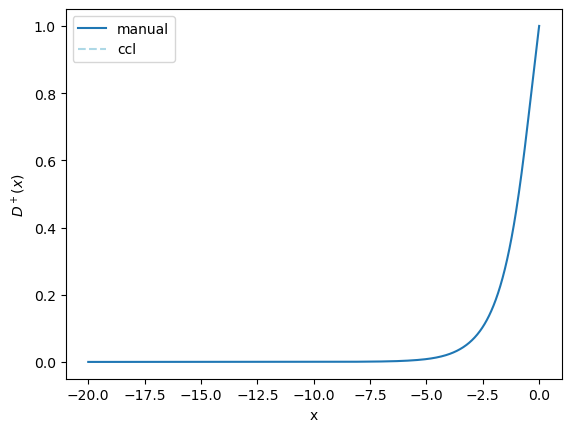

In [885]:
# Decide on some background cosmology
# note: k is unitless (ie. k is actually k/H0)
# for simga_8, k = 2pi/(8h^-1 Mpc) \implies k/H0 = 3e5*pi/400
p = 3
x_val = np.linspace( -20, 0 , int(10**p))
k_val = np.linspace(4, 3e5*np.pi/200, int(10**p + 1))
a_val = np.exp(x_val)
z_val = 1/a_val - 1
# Background cosmology for pyccl
cosmo = ccl.core.Cosmology(Omega_c=0.27,
                           Omega_b=0.045, 
                           sigma8=0.81,
                           h = 0.67,
                           n_s=0.96,
                           Omega_k=0.0, 
                           Omega_g=9.227e-5)

Soln = odeint(solverGrowth_LCDM,[0,1e-10],\
                    a_val,args=(cosmo,),mxstep=int(1e5)).T
Soln_Delta = Soln[0]
Soln_f = Soln[1]/(Soln[0]*E(x_val,cosmo,0, 0)*a_val**2)

plt.plot(x_val, Soln_Delta/Soln_Delta[-1], label = "manual")
plt.plot(x_val[9000:], ccl.growth_factor(cosmo,a_val[9000:]), label = "ccl", \
         color = "lightblue", linestyle ="--")
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$D^+(x)$")
print(Soln_Delta[0]/Soln_Delta[-1])

In [886]:
f_val = f_LCDM(x_val,cosmo)
print(len(f_val))

1000


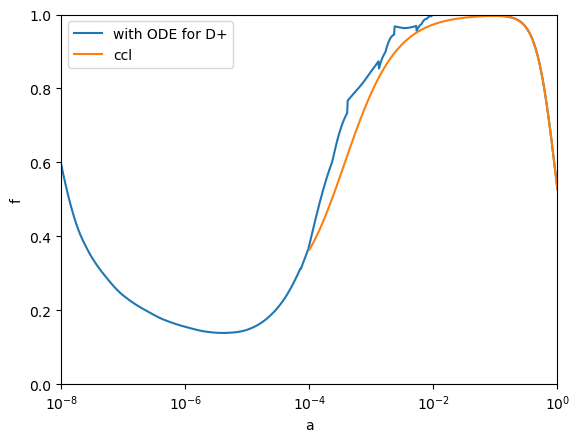

In [887]:
#plt.plot(a_val, f_val, label = "with ODE for f")
plt.plot(a_val, Soln_f, label = "with ODE for D+")
plt.plot(np.logspace(-4,0,100),ccl.growth_rate(cosmo,np.logspace(-4,0,100)), label = "ccl")

plt.xscale("log")
plt.xlabel("a")
plt.ylabel("f")
plt.legend()
plt.xlim(1e-8,1)
plt.ylim(0,1)
plt.show()

error in k_simga8 =  0.08488263631567752 %


/tmp/ipykernel_886229/2477345922.py:22: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  eta_num[i] = sc.integrate.quad(lambda x: np.exp(0.15*np.exp(3*(x - x_val[i])))/(np.exp(2*x) + 2000), -np.inf, x_val[i])[0]


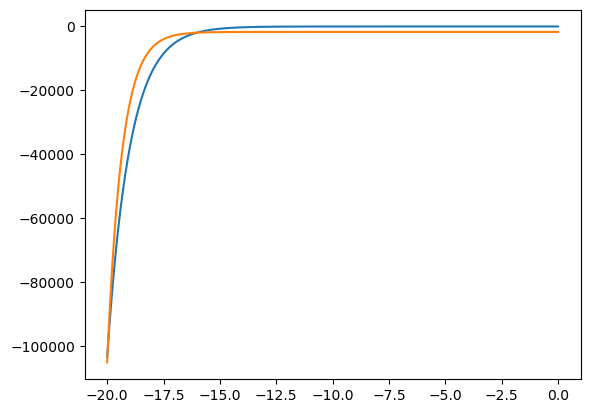

In [915]:
# ---- COSMOLOGY, SCALES AND BOUNDARY CONDITIONS -----


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

idx_sigma = find_nearest(k_val, 3e5*np.pi/400)
print("error in k_simga8 = ", 100*abs(3e5*np.pi/400 - k_val[idx_sigma])/(3e5*np.pi/400), "%")


# Example
eta_val = np.zeros(len(z_val))
#for i in range(len(z_val)):
#    eta_val[i] = eta(x_val[i],cosmo,0,0)
#plt.plot(z_val, xi(x_val,1e4, 600, cosmo))

# find eta numerically, take f_LCDM = 1 always
eta_num = np.zeros(len(x_val))
for i in range(len(x_val)):
    eta_num[i] = sc.integrate.quad(lambda x: np.exp(0.15*np.exp(3*(x - x_val[i])))/(np.exp(2*x) + 2000), -np.inf, x_val[i])[0]
    
eta_num = eta_num*0.45*np.exp(-x_val)
plt.plot(x_val,eta_num)
def Delta_m_low_x(x, cosmo):
    Omg_m = cosmo['Omega_c'] + cosmo['Omega_b']
    Omg_l = 1 - Omg_m
    return np.exp((3*Omg_m/2 - 2)*x)*(Omg_l*np.exp(3*x) + 1)**(2/3) * \
           sc.special.hyp2f1(1, Omg_m/2, (3*Omg_m+2)/6, -Omg_l*np.exp(3*x))/(3*Omg_m/2 -2)

plt.plot(x_val, (Delta_m_low_x(x_val, cosmo)- 2e11)*min(eta_num)/min(Delta_m_low_x(x_val, cosmo)))

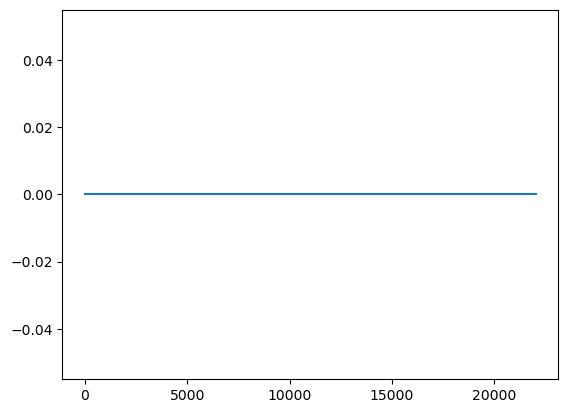

In [850]:
plt.plot(z_val, eta_val)

In [10]:
# --- FINDING SOLUTIONS ------

#find solution - 4DEGB
f = odeint(dfdx, BC, x, args=(cosmo,), mxstep=int(1e4))
f = np.transpose(f)
#find solution - LCDM
f_LCDM = odeint(dfdx, BC_LCDM, x, args=(cosmo_LCDM_array,), mxstep=int(1e4))
f_LCDM = np.transpose(f_LCDM)[0]

#find solution's theoretical error - 4DEGB
# Order of magnitude estimate of maximum BC if we assume ~ second order correction
f_max = odeint(dfdx, BC + BC_err, x, args=(cosmo,), mxstep=int(1e4))
f_max = np.transpose(f_max)

f_min = odeint(dfdx, BC - BC_err, x, args=(cosmo,), mxstep=int(1e4))
f_min = np.transpose(f_min)

#find solution's theoretical error - equivalent LCDM universe
# Order of magnitude estimate of maximum BC if we assume ~ second order correction
f_max_LCDM = odeint(dfdx, BC_LCDM + BC_err_LCDM, x, args=(cosmo_LCDM_array,), mxstep=int(1e4))
f_max_LCDM = np.transpose(f_max_LCDM)[0]

f_min_LCDM = odeint(dfdx, BC_LCDM - BC_err_LCDM, x, args=(cosmo_LCDM_array,), mxstep=int(1e4))
f_min_LCDM = np.transpose(f_min_LCDM)[0]


NameError: name 'dfdx' is not defined

NameError: name 'k_val' is not defined

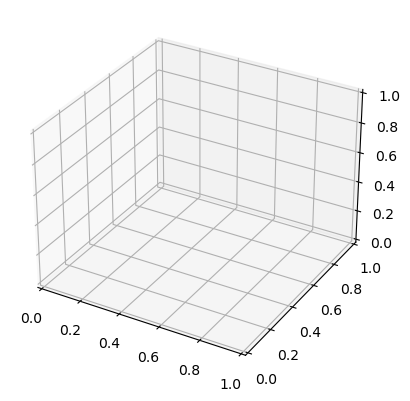

In [6]:
# 3D plot of f(a,k)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(a, k_val, f, 50)
ax.set_xlabel('a')
ax.set_ylabel('k')
ax.set_zlabel('f');

# Plot growth rate f and the fractional difference to LCDM

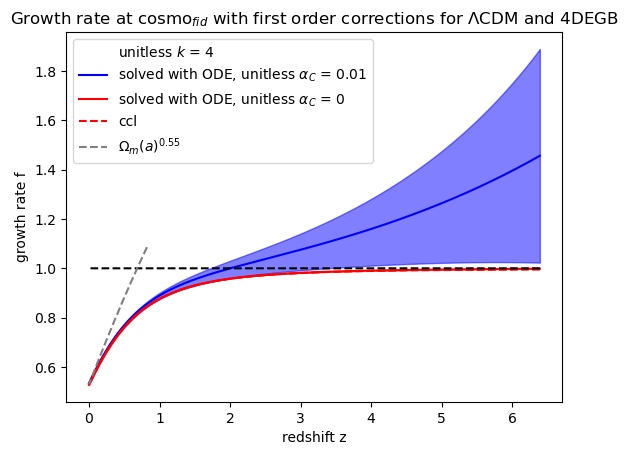

In [45]:
# plot of the growth rate with theoretical errors to to initial BC assumption, LDCM and 4DEGB
# function of z

plt.title(r"Growth rate at cosmo$_{fid}$ with first order corrections for $\Lambda$CDM and 4DEGB")
plt.plot(0,0.8,color = "white", label = r"unitless $k$ = {}".format(int(cosmo[-1][0])))
plt.plot(z,f[0], color = "b", label = r"solved with ODE, unitless $\alpha_C$ = {}".format(cosmo[-2]))
plt.fill_between(z, f_min[0], f_max[0], alpha=0.5, edgecolor='b', facecolor='b')

plt.plot(z,f_LCDM, color = "r", label = r"solved with ODE, unitless $\alpha_C$ = 0")
plt.fill_between(z, f_min_LCDM, f_max_LCDM, alpha=0.5, edgecolor='r', facecolor='r')

plt.plot(z, ccl.growth_rate(cosmoLCDM,a), color = "r", linestyle='dashed', label = "ccl")

plt.plot(z, np.ones(len(z)), color = "black", linestyle = "dashed")

plt.plot(z[7000:], ((cosmo[0] + cosmo[1])*(1+z[7000:])**3/E(x[7000:],cosmo))**0.55, color = "gray", linestyle = "dashed", label = r"$\Omega_m(a)^{0.55}$")

plt.xlabel("redshift z")
plt.ylabel("growth rate f")
#plt.xscale('log')
plt.legend()
plt.show()

# Find Delta(a) and sigma8 to first order

In [47]:
# ---- BOUNDARY CONDITIONS -------

# Can also do present day normalization as D(a = 1) = 1 (derivative?)
# Normalization to matter dominated epoc, D(a) = a * (1 - 3 Cort1 /2 -2 Cort2 /11)
# ======> dDda = 1 + 3 Cort1 - 8 Cort2 /11

Da_BC = a[0] * (1 + 2*Cort3(cosmo, z_BC)/3 - Cort_xi(cosmo, z_BC)/2)
Da_BC_LCDM = a[0] * (1 + 2*Cort3(cosmo_LCDM_array, z_BC)/3)
Da_BC_max = a[0] * (1 + 2*Cort3(cosmo, z_BC)/3 - Cort_xi(cosmo, z_BC)/2 + BC_err)
Da_BC_min = a[0] * (1 + 2*Cort3(cosmo, z_BC)/3 - Cort_xi(cosmo, z_BC)/2 - BC_err)
Da_BC_LCDM_max = a[0] * (1 + 2*Cort3(cosmo_LCDM_array, z_BC)/3 + BC_err_LCDM)
Da_BC_LCDM_min = a[0] * (1 + 2*Cort3(cosmo_LCDM_array, z_BC)/3 - BC_err_LCDM)

# BC for 4DEGB 
BCs = [Da_BC, (E(np.log(a[0]), cosmo)*a[0]**3)]

# Order of magnitude estimate of maximum BC if we assume ~ second order correction
BCs_max = [Da_BC_max, (E(np.log(a[0]), cosmo)*a[0]**3)]

BCs_min = [Da_BC_min, (E(np.log(a[0]), cosmo)*a[0]**3)]

# BC for LCDM
BCs_LCDM = [Da_BC_LCDM, (E(np.log(a[0]), cosmo_LCDM_array)*a[0]**3)]

# Order of magnitude estimate of maximum BC if we assume ~ second order correction
BCs_LCDM_max = [Da_BC_LCDM_max, (E(np.log(a[0]), cosmo_LCDM_array)*a[0]**3)]

BCs_LCDM_min = [Da_BC_LCDM_min, (E(np.log(a[0]), cosmo_LCDM_array)*a[0]**3)]

In [48]:
# ---- SOLUTIONS -------

#4DEGB solution - Delta[:,1] is Delta as a function of k, Delta[1,:] is Delta as a function of a
Soln = np.zeros((len(k_val),len(a)))
for i in range(len(k_val)):
    Soln[i] = odeint(solverGrowth, [BCs[0][i],BCs[1]], a, args=([cosmo[0],cosmo[1],cosmo[2],cosmo[3],cosmo[4],cosmo[5][i]],), mxstep=int(1e4)).T[0]

Delta = np.zeros((len(k_val),len(a)))
for j in range(len(Soln[:,-1])):
    Delta[j] = Soln[j]/Soln[j,-1]
    
# 4DEGB error
for i in range(len(k_val)):
    Soln[i] = odeint(solverGrowth,  [BCs_max[0][i],BCs_max[1]], a, args=([cosmo[0],cosmo[1],cosmo[2],cosmo[3],cosmo[4],cosmo[5][i]],), mxstep=int(1e4)).T[0]

Delta_max = np.zeros((len(k_val),len(a)))
for j in range(len(Soln[:,-1])):
    Delta_max[j] = Soln[j]/Soln[j,-1]
    
for i in range(len(k_val)):
    Soln[i] = odeint(solverGrowth,  [BCs_min[0][i],BCs_min[1]], a, args=([cosmo[0],cosmo[1],cosmo[2],cosmo[3],cosmo[4],cosmo[5][i]],), mxstep=int(1e4)).T[0]

Delta_min = np.zeros((len(k_val),len(a)))
for j in range(len(Soln[:,-1])):
    Delta_min[j] = Soln[j]/Soln[j,-1]

# LCDM solution
Soln = odeint(solverGrowth, BCs_LCDM, a, args=(cosmo_LCDM_array,), mxstep=int(1e4))
Delta_LCDM = Soln.T[0]/Soln.T[0][-1]

#LCDM error
Soln = odeint(solverGrowth, BCs_LCDM_max, a, args=(cosmo_LCDM_array,), mxstep=int(1e4))
Delta_LCDM_max = Soln.T[0]/Soln.T[0][-1]

Soln = odeint(solverGrowth, BCs_LCDM_min, a, args=(cosmo_LCDM_array,), mxstep=int(1e4))
Delta_LCDM_min = Soln.T[0]/Soln.T[0][-1]

# Plot Delta(a) or sigma8 and fsigma_8

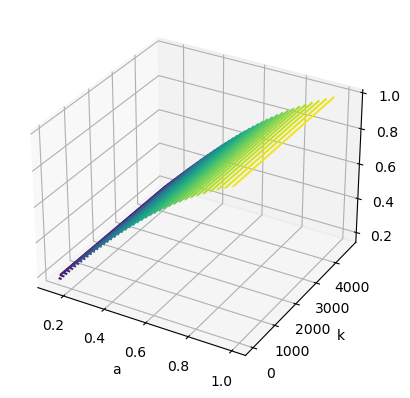

In [49]:
# 3D plot of Delta(a,k)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(a, k_val, Delta, 50)
ax.set_xlabel('a')
ax.set_ylabel('k')
ax.set_zlabel('f');

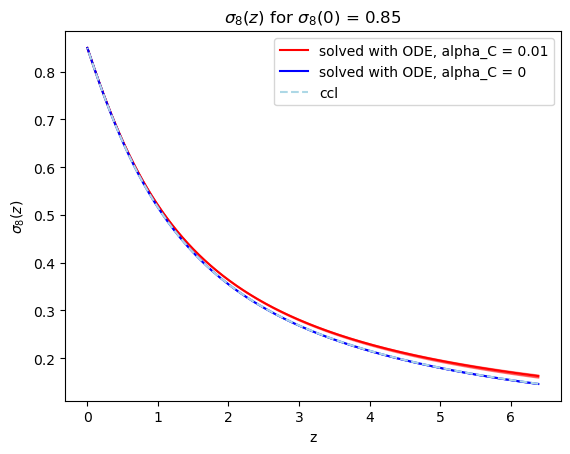

In [50]:
# plot of sigma_8(z)
sigma8 = 0.85
plt.plot(z, sigma8*Delta[idx_sigma], label  = r"solved with ODE, alpha_C = {}".format(cosmo[-2]), color = "r")
plt.fill_between(z, sigma8*Delta_min[idx_sigma], sigma8*Delta_max[idx_sigma], alpha=0.5, edgecolor='r', facecolor='r')

plt.plot(z, sigma8*Delta_LCDM, label  = r"solved with ODE, alpha_C = 0", color = "blue")
plt.fill_between(z, sigma8*Delta_LCDM_min, sigma8*Delta_LCDM_max, alpha=0.5, edgecolor='blue', facecolor='blue')

plt.plot(z, sigma8*ccl.growth_factor(cosmoLCDM,a), label = "ccl", color = "lightblue", linestyle ="--")
plt.legend()

plt.xlabel("z")
plt.ylabel(r"$\sigma_8(z)$")
plt.title(r"$\sigma_8(z)$ for $\sigma_8(0)$ = {}".format(sigma8))
plt.show()

In [ ]:
# Plot of fsimga_8(a,k)
fig = plt.figure()
ax = plt.axes(projection='3d')
z_mesh,k_mesh = np.meshgrid(z, k_val)


ls = LightSource(270, 45)
rgb = ls.shade(sigma8*f*Delta[idx_sigma], cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')

ax.plot_surface(z_mesh,k_mesh, sigma8*f*Delta[idx_sigma], rstride=1, cstride=1, facecolors=rgb,\
                linewidth=0, antialiased=False, shade=False)
ax.set_xlabel('z')
ax.set_ylabel('k')
ax.set_zlabel('fsigma_8');

In [ ]:
plt.plot(0,0.8,color = "white", label = r"unitless $k$ = {}".format(int(cosmo[-1][0])))

plt.plot(z,sigma8*f[0]*Delta[idx_sigma], label = r"solved with ODE, alpha_C = {}".format(cosmo[-2]), color = "r")
plt.fill_between(z, sigma8*f_min[0]*Delta_min[idx_sigma], sigma8*f_max[0]*Delta_max[idx_sigma], alpha=0.5, edgecolor='r', facecolor='r')

plt.plot(z,sigma8*f_LCDM*Delta_LCDM, label = "solved with ODE, alpha_C = 0", color = "b")
plt.fill_between(z, sigma8*f_min_LCDM*Delta_LCDM_min, sigma8*f_max_LCDM*Delta_LCDM_max, alpha=0.5, edgecolor='b', facecolor='b')

plt.plot(z,sigma8*ccl.growth_rate(cosmoLCDM,a)*ccl.growth_factor(cosmoLCDM,a), label = "ccl", color = "lightblue", linestyle ="--")
plt.legend()

# plot our data
plt.errorbar(z_data, fsigma8_data, yerr=err_data, fmt="o", label='data')

plt.xlabel("z")
plt.ylabel("$f\sigma_8(z)$")
plt.title(r"$f\sigma_8(z, k = 2 \pi h/8 Mpc)$ for $\sigma_8(0)$ = {}".format(sigma8))

plt.xlim(0,3)
plt.show()